#1. Дизайн эксперимента

Суть состоит в том, чтобы проверить гипотезы H0 и H.
H0 это когда p=p0 (коэффициенты конверсии старого и нового сайта равны).
H1  p != p0       (коэффициенты конверсии старого и нового сайта не равны).
Выбираем уровень доверия 95%. Необхожимо рассчитать показать alpha, который будет равен 1-0.95 = 0.05


In [3]:
#устанавливаем необходимые библиотеки
! pip install numpy pandas scipy statsmodels matplotlib seaborn

In [68]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Настройки отображения графиков
%matplotlib inline
# Стили графиков -> обращайтесь в документацию по seaborn https://seaborn.pydata.org/generated/seaborn.set_style.html
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [69]:
df = pd.read_csv('/home/mikhail/it-academy/модуль 2/Практическая часть/ab_test_inference/ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [71]:
#1. Контрольная (Control) группа - та группа пользователей, которым будет показываться старая версия сайта.
#2. Экспериментальная (Treatment) группа - та группа пользователей, которым будет показываться новая версия сайта.
# Убедимся, что контрольная группа и испытуемая видят старую страницу(standard) и новую (svm_ensemble_v_1_22)
print(pd.crosstab(df['group'], df['variants']))
print('Видно, что часть из контрольной группы видят новую страницу сайта, а часть из эксперементальной группы видят старую')

variants   standard  svm_ensemble_v_1_22
group                                   
control      145274                 1928
treatment      1965               145311
Видно, что часть из контрольной группы видят новую страницу сайта, а часть из эксперементальной группы видят старую


In [72]:
#Проверим, есть ли повторяющиеся записи в user_id
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [73]:
#используем всю выборку по условию задачи.
control_sample = df[(df['group'] == 'control') & (df['variants'] == 'standard')] #.sample(n = required_n, random_state=42)
treatment_sample = df[(df['group'] == 'treatment') & (df['variants'] == 'svm_ensemble_v_1_22') ] #.sample(n = required_n, random_state=42)
control_sample.shape #посмотрим скока строк
treatment_sample.shape #посмотрим скока строк
# Сформируем общую выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)



In [74]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290585 non-null  object
 1   timestamp  290585 non-null  object
 2   group      290585 non-null  object
 3   variants   290585 non-null  object
 4   converted  290585 non-null  int64 
 5   location   290585 non-null  object
 6   age_group  290585 non-null  object
 7   user_type  290585 non-null  object
dtypes: int64(1), object(7)
memory usage: 17.7+ MB


In [75]:
print(ab_df.group.value_counts(normalize=True))
print('Разделение пользователь на контрольную и экспериментальную группы неравномерно, так как по условию задачи используем весь набор данных')

treatment    0.500064
control      0.499936
Name: group, dtype: float64
Разделение пользователь на контрольную и экспериментальную группы неравномерно, так как по условию задачи используем весь набор данных


In [76]:
conversion_rates = ab_df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates


,CR mean,CR std,CR se
group,,,
control,0.120386,0.325413,0.000854
treatment,0.118807,0.323562,0.000849


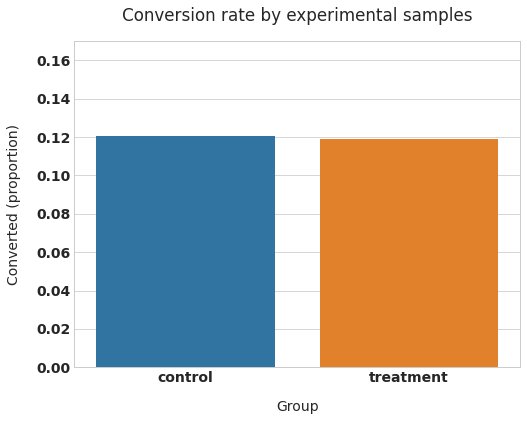

In [77]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);


In [78]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count() # общее количество пользователей, которые смотрели сайт standard
n_treat = treatment_results.count() # общее количество пользователей, которые смотрели сайт svm_ensemble_v_1_22
successes = [control_results.sum(), treatment_results.sum()] #это количество успешных испытаний, т.е. сумма 1-ц событий в нашем ab_df для контрольной и экспериментальной групп.
nobs = [n_con, n_treat] #nobs - это общее количество испытаний, т.е. Количество строк в ab_df для контрольой и экспериментальной групп.

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.31
p-value: 0.190
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.120]


In [79]:
#посчитал среднее доверительного интервала. Необходимо для вывода, чтобы сравнивать доверительные интервалы старого и нового сайта.
mean_treat = (lower_treat+upper_treat)*100/2
mean_con = (lower_con + upper_con)*100/2

Ответ на первый вопрос задания части 2

In [80]:
if pval <= 0.05:  
    print(f'p-value: {pval:.3f} <= {0.05} значит мы можем отклонить гипотезу Н0, что озночает, что новый сайт с алгоритмом svm_ensemble_v_1_22 имеет коэффициент конверсии отличный от коэффициента конверсии сайта с алгоритмом standard (новый сайт влияет на уровень конверсии), т.е на новом сайте совершают покупок больше чем на старом либо меньше')    
    if mean_con<=mean_treat < 15:
        print(f'Доверительный интервал [{lower_treat:.3f}, {upper_treat:.3f}] для экспериментальной группы. Это наш baseline, что не достигает уровня заявленных 15%. Это значит, что вероятно новый сайт будет близок  к baseline чем к заявленным 15%.')
    if mean_treat<mean_con:
        print(f'Доверительный интервал [{lower_treat:.3f}, {upper_treat:.3f}] для экспериментальной группы. Это наш baseline, что не достигает уровня заявленных 15% и значительно меньше чем коэффициент конверсии старого сайта {mean_con}%. Стоит оставить старый сайт')
    if mean_treat >= 15:
         print(f'Доверительный интервал [{lower_treat:.3f}, {upper_treat:.3f}] для экспериментальной группы. Это наш baseline, что достигает уровня заявленных 15%. Стоит оставить новый сайт')
else:
      print(f'p-value: {pval:.3f} > {0.05} значит мы не можем отклонить гипотезу Н0, что озночает, что новый сайт с алгоритмом svm_ensemble_v_1_22 имеет такой же коэффициент конверсии, что и сайт с алгоритмом standard (новый сайт не влияет на уровень конверсии), т.е на новом сайте совершают покупок почти столько же как и на старом')
      print('Поскольку количество покупок приблизительно одинаково на новом и старом сайте, то не имеет значение какой сайт оставить. Но скорее всего компании будет жалко вложенных денег на новый сайт, потраченного времени и нервов. В этом случаи стоит оставить новый вариант работы. Возможно со временем пользователи поймут привлекательность, удобство и быстроту нового сайта и коэффициент конверсии увеличится')
 

p-value: 0.190 > 0.05 значит мы не можем отклонить гипотезу Н0, что озночает, что новый сайт с алгоритмом svm_ensemble_v_1_22 имеет такой же коэффициент конверсии, что и сайт с алгоритмом standard (новый сайт не влияет на уровень конверсии), т.е на новом сайте совершают покупок почти столько же как и на старом
Поскольку количество покупок приблизительно одинаково на новом и старом сайте, то не имеет значение какой сайт оставить. Но скорее всего компании будет жалко вложенных денег на новый сайт, потраченного времени и нервов. В этом случаи стоит оставить новый вариант работы. Возможно со временем пользователи поймут привлекательность, удобство и быстроту нового сайта и коэффициент конверсии увеличится


In [81]:
#используем всю выборку по условию задачи.
control_sample = df[(df['group'] == 'control') & (df['variants'] == 'standard')] #.sample(n = required_n, random_state=42)
treatment_sample = df[(df['group'] == 'treatment') & (df['variants'] == 'svm_ensemble_v_1_22') ] #.sample(n = required_n, random_state=42)
control_sample.shape #посмотрим скока строк
treatment_sample.shape #посмотрим скока строк
# Сформируем общую выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)

In [82]:
conversion_rates = ab_df.groupby(['group','user_type'])['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

CR mean    CR std     CR se
group     user_type                                    
control   new_user         0.120894  0.326004  0.001208
          registered_user  0.119876  0.324817  0.001206
treatment new_user         0.117326  0.321808  0.001195
          registered_user  0.120282  0.325291  0.001205

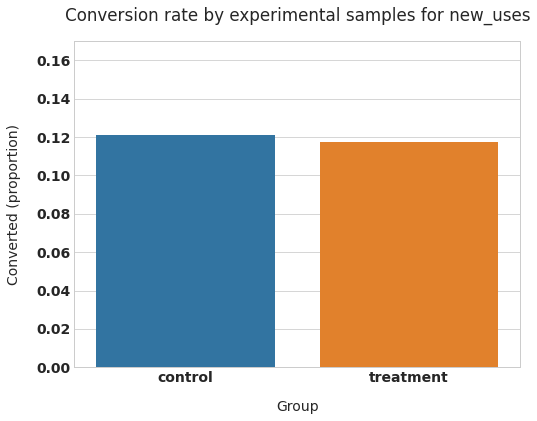

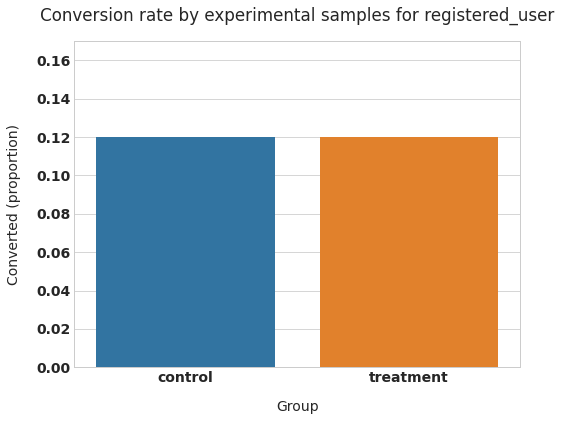

In [83]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df[(ab_df['user_type'] == 'new_user')]['group'], y=ab_df[(ab_df['user_type'] == 'new_user')]['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples for new_uses', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

plt.figure(figsize=(8,6));
sns.barplot(x=ab_df[(ab_df['user_type'] == 'registered_user')]['group'], y=ab_df[(ab_df['user_type'] == 'registered_user')]['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples for registered_user', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [84]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

def ZP_stat(type_user):
    control_results = ab_df[ab_df['group'] == 'control'].groupby('user_type')['converted']
    treatment_results = ab_df[ab_df['group'] == 'treatment'].groupby('user_type')['converted']

    n_con = control_results.count()[type_user] # пользователи, которые смотрели сайт standard
    n_treat = treatment_results.count()[type_user] # пользователи, которые смотрели сайт svm_ensemble_v_1_22


    successes = [control_results.sum()[type_user], treatment_results.sum()[type_user]] #это количество успешных испытаний, т.е. сумма 1-ц событий в нашем ab_df для контрольной и экспериментальной групп.
    nobs = [n_con, n_treat] #nobs - это общее количество испытаний, т.е. Количество строк в ab_df для контрольой и экспериментальной групп.

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    mean_treat = (lower_treat+upper_treat)*100/2
    mean_con = (lower_con + upper_con)*100/2

    print('Статистика {0}'.format(type_user))
    print(f'Z-statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

    return (pval, mean_treat, mean_con, lower_treat, upper_treat )


pval_new_user, mean_treat_new_user, mean_con_new_user, lower_treat_new_user, upper_treat_new_user = ZP_stat('new_user')
print('\n')
pval_reg_user, mean_treat_reg_user, mean_con_reg_user, lower_treat_reg_user, upper_treat_reg_user = ZP_stat('registered_user')

Статистика new_user
Z-statistic: 2.10
p-value: 0.036
CI 95% for control group: [0.119, 0.123]
CI 95% for treatment group: [0.115, 0.120]


Статистика registered_user
Z-statistic: -0.24
p-value: 0.812
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


2. Ответ на второй вопрос части 2 практического задания

In [85]:
def report(pval, mean_con, mean_treat, lower_treat, upper_treat):
    if pval <= 0.05:  
        print(f'p-value: {pval:.3f} <= {0.05} значит мы можем отклонить гипотезу Н0, что озночает, что новый сайт с алгоритмом svm_ensemble_v_1_22 имеет коэффициент конверсии отличный от коэффициента конверсии сайта с алгоритмом standard (новый сайт влияет на уровень конверсии), т.е на новом сайте совершают покупок больше чем на старом либо меньше')    
        if mean_con<=mean_treat < 15:
            print(f'Доверительный интервал [{lower_treat:.3f}, {upper_treat:.3f}] для экспериментальной группы. Это наш baseline, что не достигает уровня заявленных 15%. Это значит, что вероятно новый сайт будет близок  к baseline чем к заявленным 15%.')
        if mean_treat<mean_con:
            print(f'Доверительный интервал [{lower_treat:.3f}, {upper_treat:.3f}] для экспериментальной группы. Это наш baseline, что не достигает уровня заявленных 15% и значительно меньше чем коэффициент конверсии старого сайта {mean_con}%. Стоит оставить старый сайт')
        if mean_treat >= 15:
            print(f'Доверительный интервал [{lower_treat:.3f}, {upper_treat:.3f}] для экспериментальной группы. Это наш baseline, что достигает уровня заявленных 15%. Стоит оставить новый сайт')
    else:
        print(f'p-value: {pval:.3f} > {0.05} значит мы не можем отклонить гипотезу Н0, что озночает, что новый сайт с алгоритмом svm_ensemble_v_1_22 имеет такой же коэффициент конверсии, что и сайт с алгоритмом standard (новый сайт не влияет на уровень конверсии), т.е на новом сайте совершают покупок почти столько же как и на старом')
        print('Поскольку количество покупок приблизительно одинаково на новом и старом сайте, то не имеет значение какой сайт оставить. Но скорее всего компании будет жалко вложенных денег на новый сайт, потраченного времени и нервов. В этом случаи стоит оставить новый вариант работы. Возможно со временем пользователи поймут привлекательность, удобство и быстроту нового сайта и коэффициент конверсии увеличится')
print('Вывод для новых пользователей:')
report(pval_new_user, mean_con_new_user, mean_treat_new_user, lower_treat_new_user, upper_treat_new_user)
print('\n')
print('Вывод для зарегестрированных пользователей:')
report(pval_reg_user, mean_con_reg_user, mean_treat_reg_user, lower_treat_reg_user, upper_treat_reg_user)

Вывод для новых пользователей:
p-value: 0.036 <= 0.05 значит мы можем отклонить гипотезу Н0, что озночает, что новый сайт с алгоритмом svm_ensemble_v_1_22 имеет коэффициент конверсии отличный от коэффициента конверсии сайта с алгоритмом standard (новый сайт влияет на уровень конверсии), т.е на новом сайте совершают покупок больше чем на старом либо меньше
Доверительный интервал [0.115, 0.120] для экспериментальной группы. Это наш baseline, что не достигает уровня заявленных 15% и значительно меньше чем коэффициент конверсии старого сайта 12.08940665741644%. Стоит оставить старый сайт


Вывод для зарегестрированных пользователей:
p-value: 0.812 > 0.05 значит мы не можем отклонить гипотезу Н0, что озночает, что новый сайт с алгоритмом svm_ensemble_v_1_22 имеет такой же коэффициент конверсии, что и сайт с алгоритмом standard (новый сайт не влияет на уровень конверсии), т.е на новом сайте совершают покупок почти столько же как и на старом
Поскольку количество покупок приблизительно одинако